In [1]:
import numpy as np
import json
from PIL import Image, ImageDraw
import os
import cv2
import pandas as pd
from tqdm import tqdm
import shutil
import random

The purpose of this script is to explore images/annotations of the WIDER dataset.  
Also it converts annotations into json format.

In [2]:
# first run this script for this images:
IMAGES_DIR = os.path.expanduser('~/datasets/widerface/WIDER_train/images/')
BOXES_PATH = os.path.expanduser('~/datasets/widerface/wider_face_split/wider_face_train_bbx_gt.txt')
RESULT_DIR = os.path.expanduser('data/widerface/train/')

# then run for this images:
# IMAGES_DIR = '/home/gpu2/hdd/dan/WIDER/WIDER_val/images/'
# BOXES_PATH = '/home/gpu2/hdd/dan/WIDER/wider_face_split/wider_face_val_bbx_gt.txt'
# RESULT_DIR = '/home/gpu2/hdd/dan/WIDER/train_part2/'

# Read data

In [3]:
# collect paths to all images

all_paths = []
for path, subdirs, files in tqdm(os.walk(IMAGES_DIR)):
    for name in files:
        all_paths.append(os.path.join(path, name))
        
metadata = pd.DataFrame(all_paths, columns=['full_path'])

# strip root folder
metadata['path'] = metadata.full_path.apply(lambda x: os.path.relpath(x, IMAGES_DIR))

0it [00:00, ?it/s]

39it [00:00, 384.75it/s]

62it [00:00, 381.07it/s]

In [4]:
# see all unique endings
metadata.path.apply(lambda x: x.split('.')[-1]).unique()

array(['jpg', 'back'], dtype=object)

In [5]:
# number of images
len(metadata)

12881

In [6]:
# read annotations
with open(BOXES_PATH, 'r') as f:
    content = f.readlines()
    content = [s.strip() for s in content]

In [7]:
# split annotations by image
boxes = {}
num_lines = len(content)
i = 0
name = None

while i < num_lines:
    s = content[i]
    if s.endswith('.jpg'):
        if name is not None:
            assert len(boxes[name]) == num_boxes
        name = s
        boxes[name] = []
        i += 1
        num_boxes = int(content[i])
        i += 1
    else:
        xmin, ymin, w, h = s.split(' ')[:4]
        xmin, ymin, w, h = int(xmin), int(ymin), int(w), int(h)
        if h <= 0 or w <= 0:
            print(name)  
            # some boxes are weird!
            # so i don't use them
            num_boxes -= 1
        else:
            boxes[name].append((xmin, ymin, w, h))
        i += 1

0--Parade/0_Parade_Parade_0_452.jpg
12--Group/12_Group_Large_Group_12_Group_Large_Group_12_31.jpg
2--Demonstration/2_Demonstration_Demonstration_Or_Protest_2_666.jpg
2--Demonstration/2_Demonstration_Political_Rally_2_71.jpg
2--Demonstration/2_Demonstration_Demonstrators_2_206.jpg
2--Demonstration/2_Demonstration_Demonstration_Or_Protest_2_520.jpg
2--Demonstration/2_Demonstration_Demonstrators_2_559.jpg
2--Demonstration/2_Demonstration_Protesters_2_346.jpg
2--Demonstration/2_Demonstration_Demonstration_Or_Protest_2_202.jpg
2--Demonstration/2_Demonstration_Demonstration_Or_Protest_2_546.jpg
2--Demonstration/2_Demonstration_Demonstration_Or_Protest_2_543.jpg
2--Demonstration/2_Demonstration_Political_Rally_2_444.jpg
2--Demonstration/2_Demonstration_Demonstrators_2_373.jpg
29--Students_Schoolkids/29_Students_Schoolkids_Students_Schoolkids_29_230.jpg


33--Running/33_Running_Running_33_660.jpg
35--Basketball/35_Basketball_basketballgame_ball_35_805.jpg
35--Basketball/35_Basketball_Basketball_35_102.jpg
35--Basketball/35_Basketball_Basketball_35_220.jpg
36--Football/36_Football_americanfootball_ball_36_184.jpg
36--Football/36_Football_americanfootball_ball_36_184.jpg
36--Football/36_Football_americanfootball_ball_36_184.jpg
36--Football/36_Football_americanfootball_ball_36_184.jpg
36--Football/36_Football_americanfootball_ball_36_184.jpg
36--Football/36_Football_Football_36_63.jpg
39--Ice_Skating/39_Ice_Skating_iceskiing_39_380.jpg
46--Jockey/46_Jockey_Jockey_46_576.jpg
46--Jockey/46_Jockey_Jockey_46_717.jpg
48--Parachutist_Paratrooper/48_Parachutist_Paratrooper_Parachutist_Paratrooper_48_283.jpg
48--Parachutist_Paratrooper/48_Parachutist_Paratrooper_Parachutist_Paratrooper_48_258.jpg
54--Rescue/54_Rescue_rescuepeople_54_29.jpg
7--Cheering/7_Cheering_Cheering_7_17.jpg


In [8]:
# check that all images have bounding boxes
assert metadata.path.apply(lambda x: x in boxes).all()

AssertionError: 

# Show some bounding boxes

In [9]:
def draw_boxes_on_image(path, boxes):

    image = Image.open(path)
    draw = ImageDraw.Draw(image, 'RGBA')
    width, height = image.size

    for b in boxes:
        xmin, ymin, w, h = b
        xmax, ymax = xmin + w, ymin + h

        fill = (255, 255, 255, 45)
        outline = 'red'
        draw.rectangle(
            [(xmin, ymin), (xmax, ymax)],
            fill=fill, outline=outline
        )
    return image

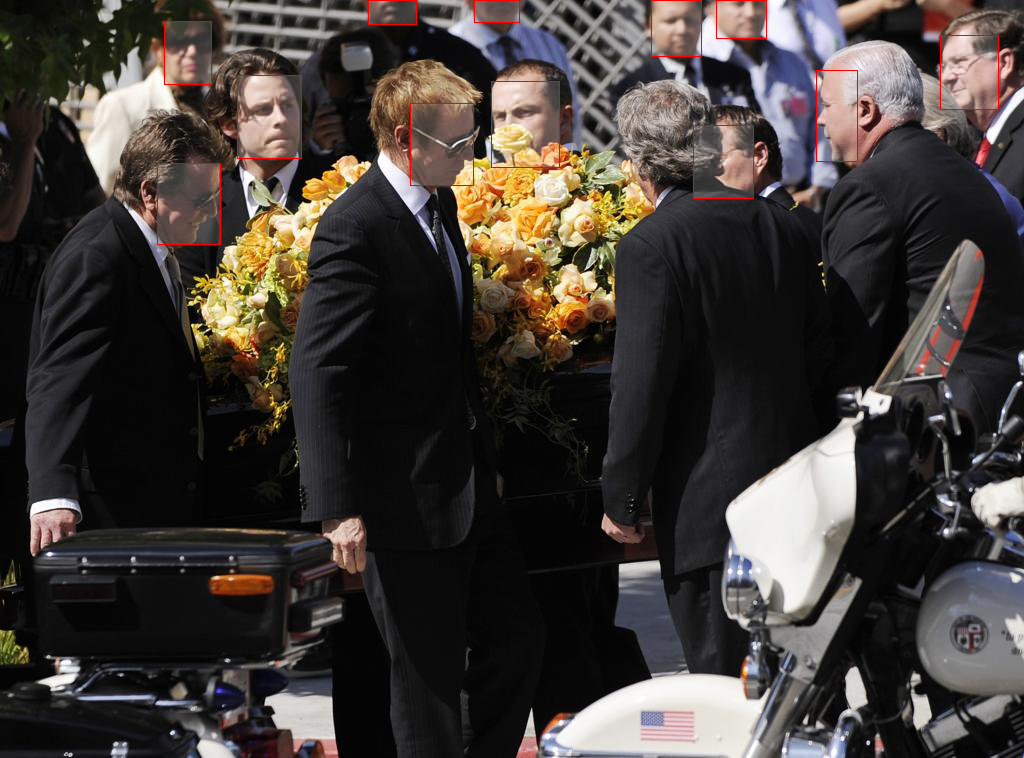

In [10]:
i = random.randint(0, len(metadata) - 1)  # choose a random image
some_boxes = boxes[metadata.path[i]]
draw_boxes_on_image(metadata.full_path[i], some_boxes)

# Convert

In [11]:
def get_annotation(path, width, height):
    name = path.split('/')[-1]
    annotation = {
      "filename": name,
      "size": {"depth": 3, "width": width, "height": height}
    }
    objects = []
    for b in boxes[path]:
        xmin, ymin, w, h = b
        xmax, ymax = xmin + w, ymin + h
        objects.append({
            "bndbox": {"ymin": ymin, "ymax": ymax, "xmax": xmax, "xmin": xmin}, 
            "name": "face"
        })
    annotation["object"] = objects
    return annotation

In [13]:
# create a folder for the converted dataset
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)
shutil.rmtree(RESULT_DIR, ignore_errors=True)
os.mkdir(RESULT_DIR)
os.mkdir(os.path.join(RESULT_DIR, 'images'))
os.mkdir(os.path.join(RESULT_DIR, 'annotations'))

In [14]:
for T in tqdm(metadata.itertuples()):
    
    # get width and height of an image
    image = cv2.imread(T.full_path)
    h, w, c = image.shape
    assert c == 3
    
    # name of the image
    name = T.path.split('/')[-1]
    assert name.endswith('.jpg')

    # copy the image
    shutil.copy(T.full_path, os.path.join(RESULT_DIR, 'images', name))
    
    # save annotation for it
    d = get_annotation(T.path, w, h)
    json_name = name[:-4] + '.json'
    json.dump(d, open(os.path.join(RESULT_DIR, 'annotations', json_name), 'w')) 

0it [00:00, ?it/s]

2it [00:00, 10.96it/s]

9it [00:00, 31.67it/s]

25it [00:00, 63.85it/s]

36it [00:00, 72.86it/s]

54it [00:00, 90.39it/s]

68it [00:00, 97.41it/s]

80it [00:00, 98.16it/s]

92it [00:00, 92.59it/s]

102it [00:01, 91.56it/s]

112it [00:01, 90.31it/s]

125it [00:01, 93.01it/s]

141it [00:01, 97.43it/s]

159it [00:01, 102.67it/s]

179it [00:01, 108.57it/s]

199it [00:01, 113.69it/s]

217it [00:01, 117.11it/s]

234it [00:01, 118.51it/s]

251it [00:02, 119.50it/s]

267it [00:02, 115.91it/s]

281it [00:02, 114.72it/s]

295it [00:02, 115.37it/s]

314it [00:02, 117.92it/s]

330it [00:02, 119.16it/s]

345it [00:02, 118.26it/s]

359it [00:03, 115.53it/s]

377it [00:03, 117.11it/s]

391it [00:03, 117.72it/s]

405it [00:03, 116.11it/s]

417it [00:03, 115.66it/s]

434it [00:03, 116.77it/s]

447it [00:03, 116.01it/s]

461it [00:03, 116.26it/s]

473it [00:04, 115.75it/s]

491it [00:04, 117.27it/s]

509it [00:04, 118.67it/s]

524it [00:04, 119.25it/s]

543it [00:04, 120.54it/s]

561it [00:04, 121.69it/s]

581it [00:04, 123.29it/s]

601it [00:04, 124.76it/s]

622it [00:04, 126.42it/s]

641it [00:05, 126.56it/s]

658it [00:05, 124.04it/s]

674it [00:05, 124.50it/s]

689it [00:05, 123.86it/s]

702it [00:05, 122.11it/s]

718it [00:05, 122.70it/s]

731it [00:06, 121.77it/s]

744it [00:06, 121.64it/s]

757it [00:06, 121.64it/s]

772it [00:06, 122.02it/s]

785it [00:06, 122.09it/s]

798it [00:06, 122.14it/s]

811it [00:06, 122.06it/s]

824it [00:06, 121.57it/s]

836it [00:06, 121.45it/s]

849it [00:06, 121.29it/s]

867it [00:07, 122.12it/s]

881it [00:07, 121.34it/s]

893it [00:07, 120.26it/s]

904it [00:07, 118.48it/s]

914it [00:07, 118.18it/s]

924it [00:07, 117.61it/s]

934it [00:07, 117.39it/s]

944it [00:08, 116.44it/s]

953it [00:08, 115.83it/s]

964it [00:08, 115.72it/s]

974it [00:08, 115.50it/s]

984it [00:08, 114.85it/s]

994it [00:08, 114.66it/s]

1004it [00:08, 114.41it/s]

1014it [00:08, 113.76it/s]

1024it [00:09, 113.50it/s]

1033it [00:09, 113.03it/s]

1043it [00:09, 112.86it/s]

1052it [00:09, 112.10it/s]

1065it [00:09, 112.23it/s]

1078it [00:09, 112.35it/s]

1089it [00:09, 112.21it/s]

1100it [00:09, 111.86it/s]

1110it [00:09, 111.56it/s]

1121it [00:10, 111.54it/s]

1131it [00:10, 111.40it/s]

1143it [00:10, 111.35it/s]

1155it [00:10, 111.37it/s]

1166it [00:10, 111.03it/s]

1177it [00:10, 110.77it/s]

1187it [00:10, 109.29it/s]

1195it [00:10, 108.68it/s]

1203it [00:11, 108.31it/s]

1213it [00:11, 108.16it/s]

1226it [00:11, 108.23it/s]

1235it [00:11, 107.71it/s]

1250it [00:11, 107.93it/s]

1260it [00:11, 107.60it/s]

1273it [00:11, 107.75it/s]

1284it [00:11, 107.63it/s]

1299it [00:12, 107.89it/s]

1311it [00:12, 107.22it/s]

1321it [00:12, 106.58it/s]

1332it [00:12, 106.56it/s]

1342it [00:12, 104.45it/s]

1350it [00:13, 100.31it/s]

1356it [00:14, 94.97it/s] 

1361it [00:14, 93.62it/s]

1365it [00:14, 92.64it/s]

1368it [00:14, 92.10it/s]

1376it [00:14, 91.98it/s]

1383it [00:15, 91.82it/s]

1396it [00:15, 92.05it/s]

1404it [00:15, 88.73it/s]

1410it [00:16, 87.55it/s]

1419it [00:16, 87.52it/s]

1428it [00:16, 87.49it/s]

1436it [00:16, 87.43it/s]

1446it [00:16, 87.50it/s]

1455it [00:16, 87.48it/s]

1467it [00:16, 87.65it/s]

1477it [00:16, 87.67it/s]

1487it [00:16, 87.59it/s]

1502it [00:17, 87.77it/s]

1512it [00:17, 87.70it/s]

1521it [00:17, 87.59it/s]

1531it [00:17, 87.64it/s]

1540it [00:17, 87.49it/s]

1550it [00:17, 87.54it/s]

1563it [00:17, 87.65it/s]

1573it [00:17, 87.42it/s]

1582it [00:18, 84.06it/s]

1589it [00:18, 83.69it/s]

1601it [00:19, 83.84it/s]

1612it [00:19, 83.93it/s]

1622it [00:19, 84.01it/s]

1633it [00:19, 84.11it/s]

1643it [00:19, 84.17it/s]

1653it [00:19, 84.23it/s]

1664it [00:19, 84.34it/s]

1674it [00:20, 82.52it/s]

1682it [00:20, 82.43it/s]

1693it [00:20, 82.54it/s]

1702it [00:20, 82.51it/s]

1713it [00:20, 82.64it/s]

1725it [00:20, 82.77it/s]

1736it [00:20, 82.88it/s]

1746it [00:21, 82.85it/s]

1758it [00:21, 82.98it/s]

1769it [00:21, 83.09it/s]

1779it [00:21, 83.14it/s]

1796it [00:21, 83.54it/s]

1808it [00:21, 83.69it/s]

1822it [00:21, 83.93it/s]

1835it [00:21, 84.12it/s]

1850it [00:21, 84.38it/s]

1864it [00:22, 84.63it/s]

1878it [00:22, 84.85it/s]

1892it [00:22, 84.11it/s]

1904it [00:22, 84.26it/s]

1915it [00:22, 84.36it/s]

1926it [00:22, 84.38it/s]

1937it [00:22, 84.38it/s]

1951it [00:23, 84.61it/s]

1964it [00:23, 84.81it/s]

1976it [00:23, 84.89it/s]

1988it [00:23, 84.96it/s]

1999it [00:23, 85.04it/s]

2010it [00:23, 85.09it/s]

2026it [00:23, 85.40it/s]

2039it [00:23, 85.56it/s]

2051it [00:23, 85.62it/s]

2063it [00:24, 85.66it/s]

2075it [00:24, 85.79it/s]

2088it [00:24, 85.94it/s]

2103it [00:24, 86.20it/s]

2120it [00:24, 86.53it/s]

2134it [00:24, 86.68it/s]

2148it [00:24, 86.86it/s]

2161it [00:24, 87.01it/s]

2174it [00:24, 87.05it/s]

2188it [00:25, 87.24it/s]

2201it [00:25, 87.15it/s]

2212it [00:25, 87.22it/s]

2225it [00:25, 87.35it/s]

2237it [00:25, 87.46it/s]

2251it [00:25, 87.63it/s]

2263it [00:25, 87.64it/s]

2279it [00:25, 87.90it/s]

2293it [00:26, 88.09it/s]

2308it [00:26, 88.31it/s]

2322it [00:26, 88.42it/s]

2337it [00:26, 88.63it/s]

2350it [00:26, 88.78it/s]

2363it [00:26, 88.92it/s]

2380it [00:26, 89.19it/s]

2395it [00:26, 89.40it/s]

2409it [00:26, 89.29it/s]

2421it [00:27, 89.20it/s]

2436it [00:27, 89.24it/s]

2447it [00:28, 87.13it/s]

2455it [00:28, 86.26it/s]